# BIMODAL HM (analytical calculation is not done)

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

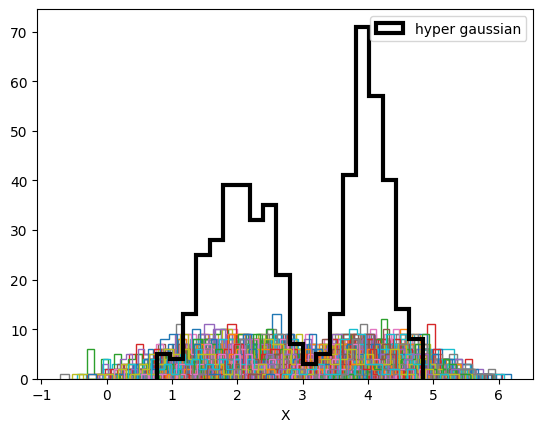

In [2]:
N_obs = 500
size_child = 50

true_parent_mean_A = 2.0 # hyperparameter
true_parent_scale_A = .5 # hyperparameter
true_parent_mean_B = 4.0 # hyperparameter
true_parent_scale_B = .3 # hyperparameter

true_child_scale = 0.5

parent_gaussian = np.concatenate((np.random.normal(loc=true_parent_mean_A, scale=true_parent_scale_A, size=N_obs//2), 
                                  np.random.normal(loc=true_parent_mean_B, scale=true_parent_scale_B, size=N_obs//2)),
                                )

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

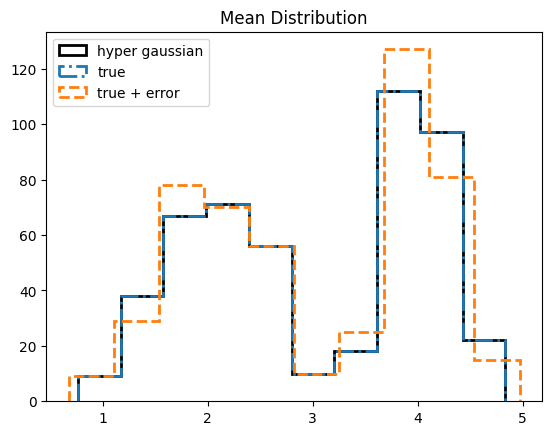

In [3]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [4]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B : (
                                (2 * np.pi * parent_scale_A**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_A)**2 / (2 * parent_scale_A**2)) + \
                                (2 * np.pi * parent_scale_B**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_B)**2 / (2 * parent_scale_B**2))
                                ) * \
                                            size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial)
mu_A_ml, sigma_A_ml, mu_B_ml, sigma_B_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu_A = {0:.3f}".format(mu_A_ml))
print("sigma_A = {0:.3f}".format(sigma_A_ml))
print("mu_B = {0:.3f}".format(mu_B_ml))
print("sigma_B = {0:.3f}".format(sigma_B_ml))

Maximum likelihood estimates:
mu_A = 2.021
sigma_A = 0.496
mu_B = 4.037
sigma_B = 0.318


/tmp/ipykernel_26363/2896788237.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_26363/2896788237.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/tmp/ipykernel_26363/2896788237.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_26363/2896788237.py:10: RuntimeWarning: divide by zero encountered in log
  return np

In [6]:
def log_prior(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    # Flat priors 
    if (0 < parent_mean_A < 5 and 
        0 < parent_scale_A < 1 and
        0 < parent_mean_B < 5 and 
        0 < parent_scale_B < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [7]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [01:23<00:00, 96.11it/s] 


State([[2.08045643 0.5048048  4.01304705 0.30836881]
 [2.01646963 0.50790987 4.03285803 0.32590228]
 [2.02126229 0.51210826 4.04952343 0.34307755]
 [1.97353783 0.48113918 4.02699996 0.30241879]
 [2.04820679 0.51290826 4.03086732 0.3218018 ]
 [1.98008971 0.50299178 4.0019431  0.34037994]
 [2.02617611 0.50711527 4.05108077 0.34265403]
 [1.96839709 0.50075542 3.98998008 0.31648827]
 [2.02557079 0.45622072 4.05738813 0.3463583 ]
 [1.99565196 0.50354955 4.04194445 0.29843945]
 [2.03243159 0.51056205 4.05006909 0.3321103 ]
 [1.99274694 0.50304195 4.03166096 0.30609426]
 [2.03224861 0.55614562 4.05496152 0.28643128]
 [2.0440492  0.4647695  3.97843331 0.33316654]
 [2.03632926 0.50222622 4.03250492 0.32063667]
 [1.96290841 0.45026146 4.04387118 0.33034718]
 [2.05179968 0.52935778 4.0327374  0.33218796]
 [2.00703989 0.49801949 4.02860772 0.31488566]
 [2.00462773 0.52657996 4.00488736 0.32934528]
 [2.05325807 0.51999174 4.00419337 0.31312805]
 [2.04009273 0.54499557 4.05265668 0.31668413]
 [2.059

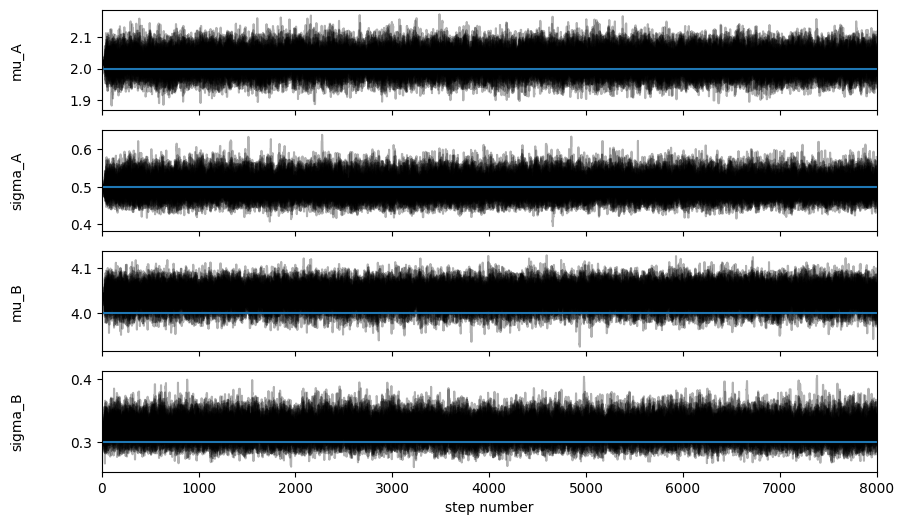

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 6), sharex=True)
samples = sampler.get_chain()
labels = ["mu_A", "sigma_A", "mu_B", "sigma_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].hlines(true_parent_mean_A, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale_A, 0, len(samples))
axes[2].hlines(true_parent_mean_B, 0, len(samples))
axes[3].hlines(true_parent_scale_B, 0, len(samples))

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[47.63139842 45.56269153 43.3855282  46.7710715 ]


In [10]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(26300, 4)


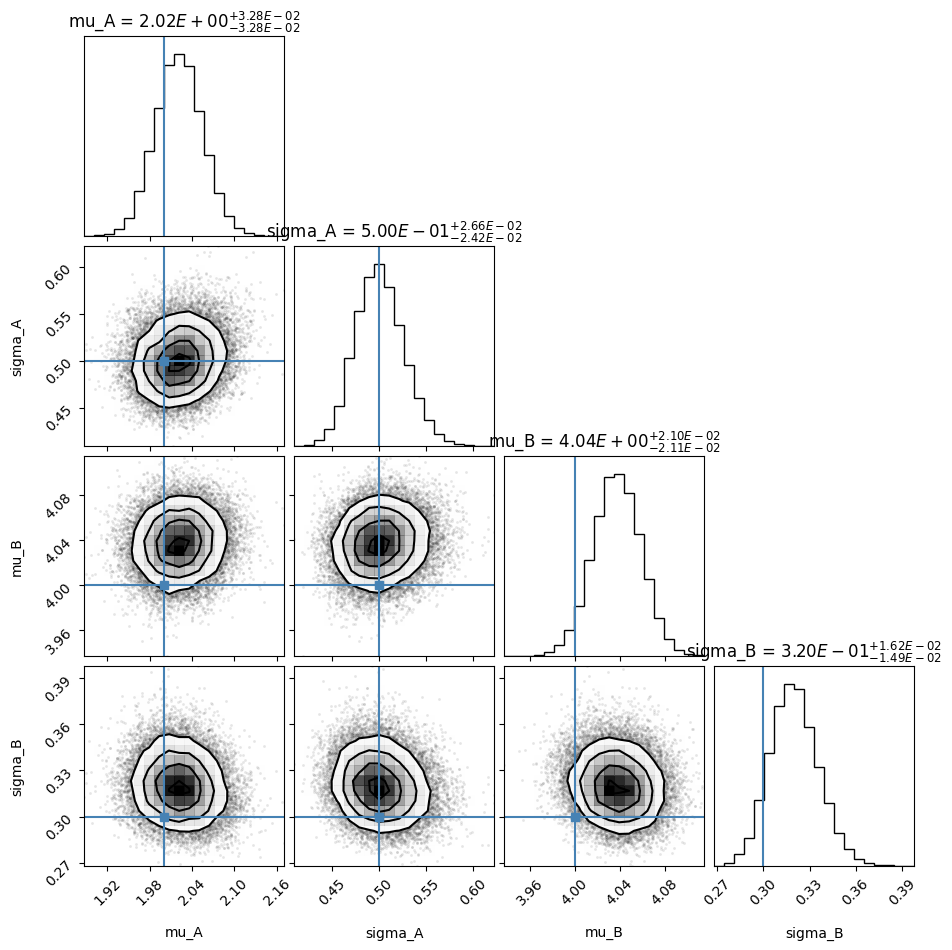

In [11]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)